# Call Centre Department - Forecast Analysis

This is the final for the visualization on Power BI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

In [2]:
df = pd.read_csv('../../Data/Call Centre Dept/Call_Centre_CLEANED_Final.csv')

In [3]:
df.head()

,Date,Queue,Agent,Event,Wait Time,Talk Time,Country,Description,Team,Calls_Offered,Calls_Answered,Wait_Time_<=20s,Wait_Time_<=30s,Weekday,Inbound_Outbound
0,2021-01-01 00:14:00,CPAC - 0 - Night,Anne Chia - PSCS,COMPLETECALLER,00:00:05,00:02:01,PSCS,CPAC - 0 - Night,HOSP,1,1,1,1,Friday,Inbound
1,2021-01-01 00:14:00,PSCS-Outbound,Anne Chia - PSCS,COMPLETEAGENT,00:00:14,00:00:14,PSCS,PSCS-Outbound,Outbound,1,1,1,1,Friday,Outbound
2,2021-01-01 00:38:00,PEPAC - Press 0 - Night,Anne Chia - PSCS,COMPLETECALLER,00:00:07,00:02:12,PSCS,PEPAC - Press 0 - Night,HOSP,1,1,1,1,Friday,Inbound
3,2021-01-01 00:39:00,PSCS-Outbound,Anne Chia - PSCS,COMPLETEAGENT,00:00:15,00:00:34,PSCS,PSCS-Outbound,Outbound,1,1,1,1,Friday,Outbound
4,2021-01-01 02:06:00,PEPAC - Press 0 - Night,Nurrifah - PSCS,COMPLETECALLER,00:00:06,00:04:11,PSCS,PEPAC - Press 0 - Night,HOSP,1,1,1,1,Friday,Inbound


## Forecasting with SARIMA for Calls Offered

In [4]:
#Disect data of Date and Calls Offered ONLY
call_off_df = df[['Date', 'Calls_Offered']]
call_off_df

,Date,Calls_Offered
0,2021-01-01 00:14:00,1
1,2021-01-01 00:14:00,1
2,2021-01-01 00:38:00,1
3,2021-01-01 00:39:00,1
4,2021-01-01 02:06:00,1
...,...,...
785602,2021-03-31 23:15:00,1
785603,2021-03-31 23:16:00,1
785604,2021-03-31 23:17:00,1
785605,2021-03-31 23:19:00,1


In [5]:
#Check for null values
call_off_df.isnull().sum()

Date             0
Calls_Offered    0
dtype: int64

In [6]:
#Check info
call_off_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785607 entries, 0 to 785606
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Date           785607 non-null  object
 1   Calls_Offered  785607 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.0+ MB


In [7]:
#to ensure that those with discrepencies are properly fixed for SARIMA
call_off_df = call_off_df.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

In [8]:
#Change 'Date' column to datetime
call_off_df['Date'] = pd.to_datetime(call_off_df['Date'], infer_datetime_format=True)
#Set as index
call_off_df = call_off_df.set_index('Date')

In [9]:
#Select the proper time period for weekly aggregation
call_off_df = call_off_df['2021-01-01':'2021-12-31'].resample('W').sum()
call_off_df.head()

C:\Users\sherm\AppData\Local\Temp\ipykernel_21500\2934494826.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  call_off_df = call_off_df['2021-01-01':'2021-12-31'].resample('W').sum()


,Calls_Offered
Date,
2021-01-03,5292
2021-01-10,17792
2021-01-17,14886
2021-01-24,14984
2021-01-31,14512


### Create Training & Testing Datasets

Training and Testing Datasets need to change the range for future analysis purposes and to ensure it's accuracy.

In [10]:
y = call_off_df['Calls_Offered']

#set y_to_train, y_to_test, and the length of predict units
y_to_train = y[:'2021-06-30'] #dataset to train
y_to_test = y['2021-07-01':] #last X months for test

predict_date = len(y) - len(y[:'2021-06-30']) # the number of data points for the test set

### SARIMA Parameters Check

Whenever there's new data, there is a need to re-run this to get the best suitable parameters for the forecast.

In [11]:
#sarima parameters check
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [12]:
#assuming seasonal period = 12, can be changed based on variances and type of result needed
sarima_grid_search(y,12)

C:\Users\sherm\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sherm\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sherm\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sherm\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

The set of parameters with the minimum AIC is: SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:512.9419660646779


C:\Users\sherm\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### SARIMA One-Step ahead & Dynamic forecast

This is to check if SARIMA is suitable for your dataset, as well as to analyze train & test results based on current dataset.

In [13]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Calls Offered')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Calls Offered')

    plt.legend()
    plt.show()
    
    return (results)

Based on previous results, 

The set of parameters with the minimum AIC is: SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:512.9419660646779

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3669      0.186     -1.971      0.049      -0.732      -0.002
ar.S.L12      -0.4798      0.085     -5.632      0.000      -0.647      -0.313
sigma2       8.35e+06   2.49e-09   3.35e+15      0.000    8.35e+06    8.35e+06


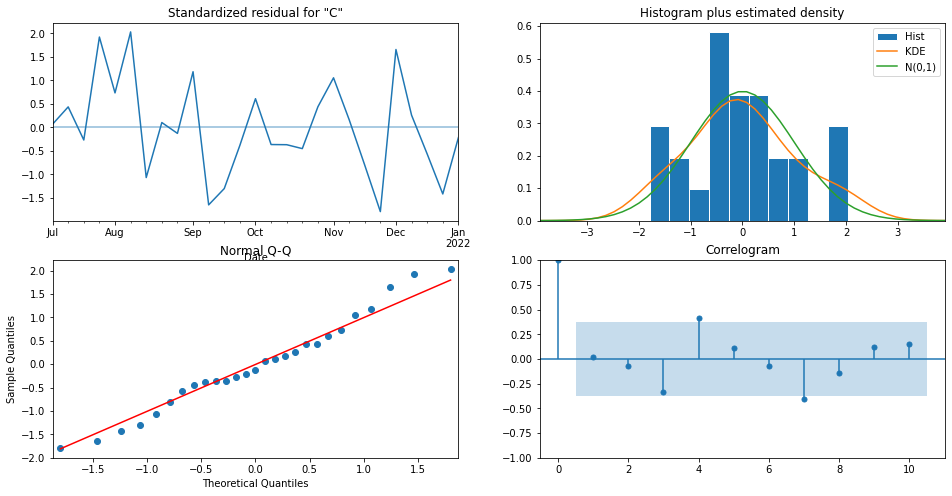

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 2889.61


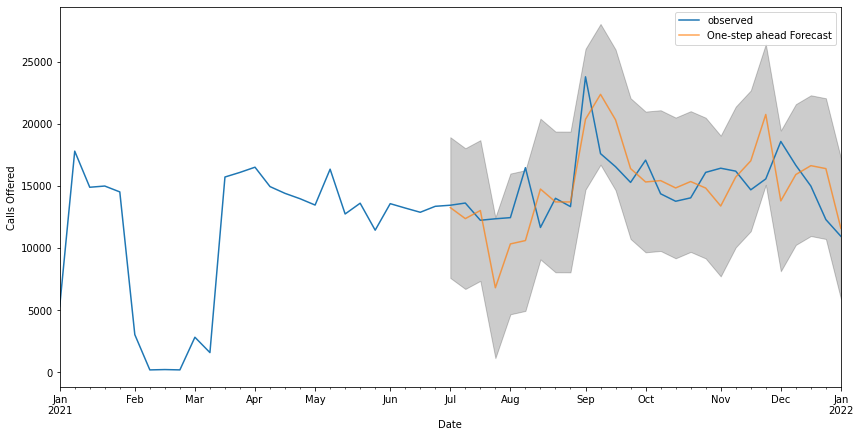

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 6732.7


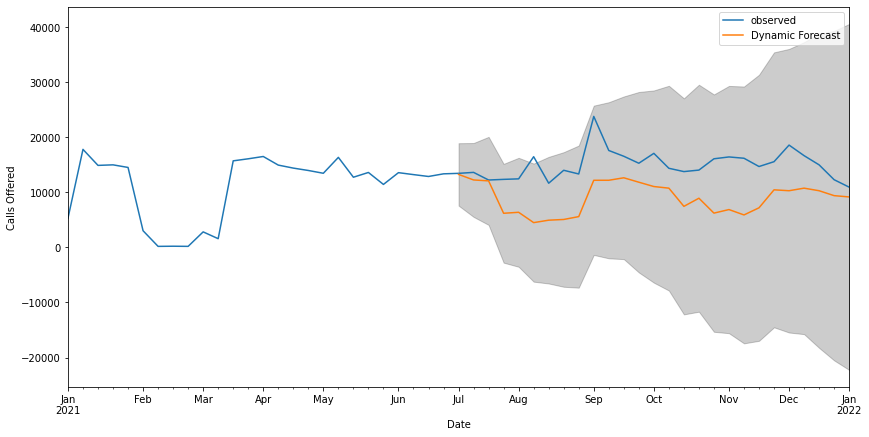

In [14]:
model = sarima_eva(y,(1,1,0),(1,1,0,12),12,'2021-07-04',y_to_test)

### Making Predictions

In [15]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

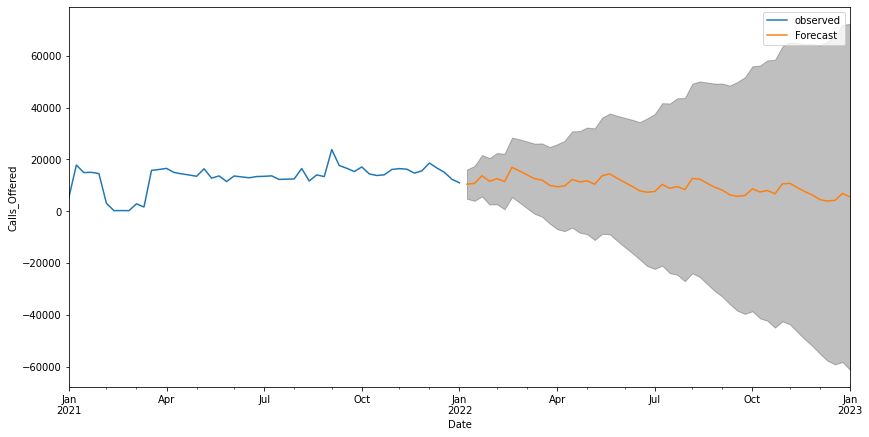

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-01-09,10414.028026,4750.508406,16077.547647
1,2022-01-16,10698.939828,3995.710917,17402.168740
2,2022-01-23,13659.238249,5669.330868,21649.145631
3,2022-01-30,11537.504740,2571.435832,20503.573648
4,2022-02-06,12536.380389,2647.627235,22425.133544


In [16]:
final_table = forecast(model,52,y)
final_table.head()

## Coding for PowerBI

For copy/paste and transfer over to Power BI purposes. 

Before transferring the code to Power BI, export call_off_df into a csv (index=True)

In [17]:
call_off_df.to_csv('../../Data/Call Centre Dept/Calls_Offered_Groupby_Week_for_Forecast.csv', index=True)

In [18]:
#export predicted values into csv --> to view the exact values on PowerBI
final_table.to_csv('../../Data/Call Centre Dept/Calls_Offered_Predicted_Values_for_2022.csv', index=True)

Afterwhich, import the following csv above into Power BI to build a Python Visual.

Copy/Paste the following into Power BI Python Query Editor after creating the above. 

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm

dataset['Date'] = pd.to_datetime(dataset['Date'], infer_datetime_format=True)
dataset = dataset.set_index('Date')

y = dataset['Calls_Offered']
y_to_train = y[:'2021-06-30']
y_to_test = y['2021-07-01':]
predict_date = len(y) - len(y[:'2021-06-30'])
               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()

    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    
    return (results)

def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(20, 12))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

#These values will change depending on the dataset
model = sarima_eva(y,(1,1,0),(1,1,0,12),12,'2021-07-04',y_to_test)
final_table = forecast(model,52,y)
```